In [2]:
from src import data_loader as dl
from src.model_utils import ExactGPModel
import numpy as np
import torch
import gpytorch


## Preprocessing Steps

In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16
N_SYSTEMS = 10
RADIUS = 0.5

In [4]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 14 m : 59 sec



In [5]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location, df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv, 8, 16)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv, 0.05)


Dropping 27 systems producing over night


In [6]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                        df_location=df_location)
df_pv['datetime'] = datetime

In [7]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [4]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [5]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [6]:
N_DAYS = 3
N_SYSTEMS = 10
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL

COORDS = (52.1074, -0.1278)

In [7]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

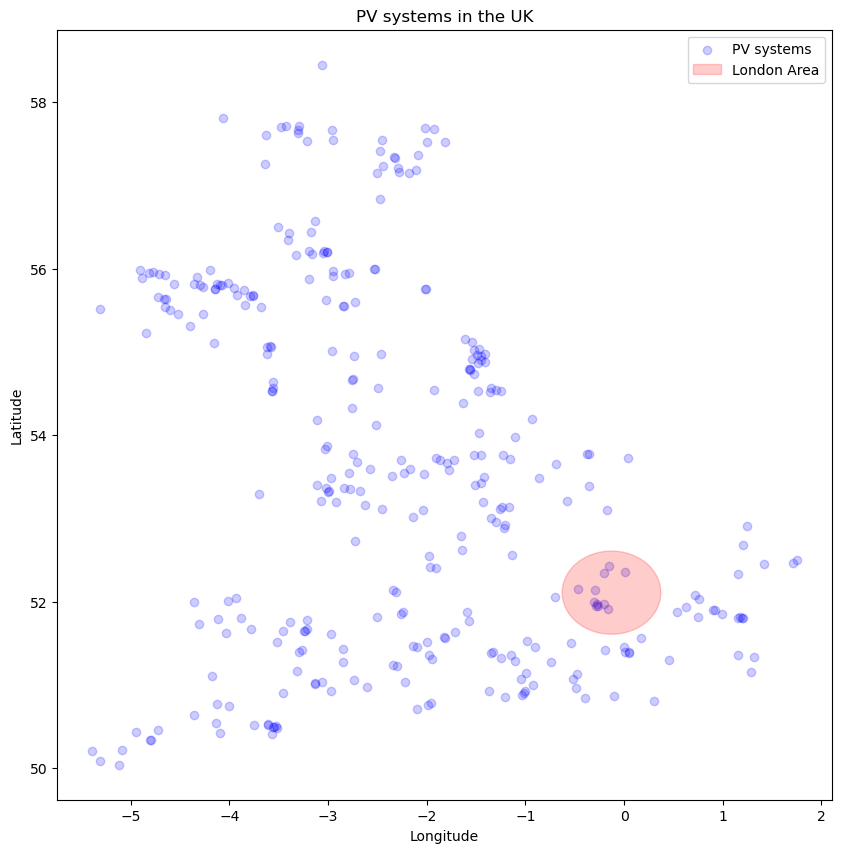

In [8]:
from src.plot_utils import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [9]:
systems, pv_systems = dl.align_pv_systems(systems, df_pv)
pv_sample = pv_systems.iloc[:int(N_DAYS * DAILY_DATA_POINTS) , :N_SYSTEMS]

In [10]:
lats, longs = dl.get_location_maps(df_location=systems, 
                                   n_systems=N_SYSTEMS)
n_samples = int(N_DAYS * DAILY_DATA_POINTS)
pv_sample['datetime'] = datetime[n_samples:2*n_samples]

In [11]:
pv_stack = dl.stack_dataframe(df_pv=pv_sample,
                                  lats_map=lats,
                                  longs_map=longs)

In [12]:
dl.save_csv(pv_stack, 'pv_data', 'pv_data_stack.csv')

In [13]:
X = pv_stack[['epoch', 'latitude', 'longitude']].values
y = pv_stack['PV'].values

In [14]:
time, r_grid, y = dl.create_spatiotemporal_grid(X, y)

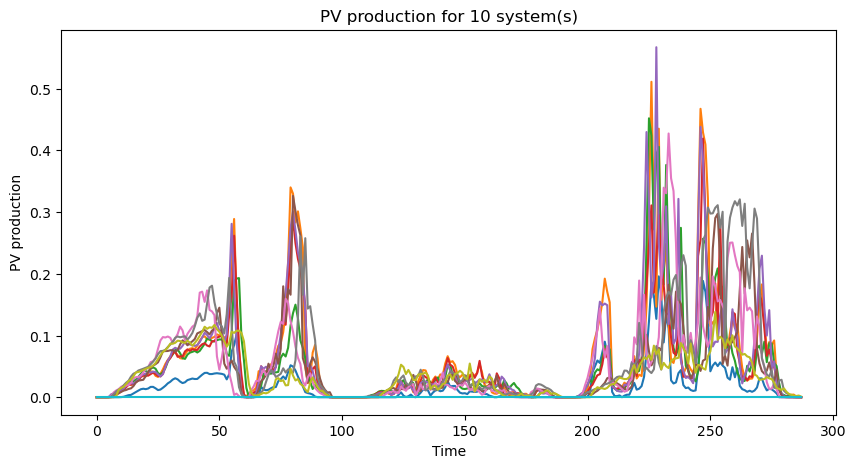

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time, y[:,:,0])

ax.set_xlabel('Time')
ax.set_ylabel('PV production')
ax.set_title(f'PV production for {y.shape[1]} system(s)');

In [16]:
time_tensor, r_grid, y_tensor = dl.convert_grid_to_tensor(time=time,
                                                          r_grid=r_grid,
                                                          y=y)

In [38]:
def train_gp(x, y, n_hours, n_iter, lr, optim, likelihood, mean_module, covar_module):
    """
    Train the GP model

    Args:
        train_x (torch.Tensor): training data
        train_y (torch.Tensor): training labels
        n_iter (int): number of iterations
        lr (float): learning rate
        optim (str): optimizer
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module

    Returns:
        ExactGPModel: trained GP model
    """

    
    y_copy = torch.zeros(y.shape)
    y_copy[:, :, 0] = y[:, :, 0]
    
    for k in range(y.shape[1]):
        time, y_sample = dl.extract_time_series(time=x, y=y, idx=k)
        time_train, y_train, time_test, _ = dl.train_test_split(time, y_sample, n_hours=n_hours)
        model = ExactGPModel(time_train, y_train, likelihood, mean_module, covar_module)
        model._train(n_iter, lr, optim)
        preds_test, _ = model.predict(time_test)
        
        y_copy[len(time_train):, k, 0] = preds_test.mean
        
    return y_copy

In [81]:
def create_gp_covars(time, pv_series, index_to_drop, likelihood, mean_module, covar_module):

    # Create the complementary indices to keep
    indices_to_keep = [i for i in range(pv_series.size(1)) if i != index_to_drop]

    # Select the desired time series
    pv_input = torch.index_select(pv_series, dim=1, index=torch.tensor(indices_to_keep))
    pv_pred = train_gp(x=time_tensor,
            y=pv_input,
            n_hours=2,
            n_iter=500,
            lr=0.05,
            optim='Adam',
            likelihood=likelihood,
            mean_module=mean_module,
            covar_module=covar_module)

    covars = torch.cat((time, pv_pred.squeeze()), dim=1)
    target = pv_series[:, index_to_drop, :]

    return covars, target


In [134]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
mean_module = gpytorch.means.ConstantMean()
matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
periodic_kernel = gpytorch.kernels.PeriodicKernel()

covar_module = matern_kernel  * periodic_kernel

covars, target = create_gp_covars(time_tensor, y_tensor, 8, likelihood, mean_module, covar_module)

Iter 1/500 - Loss: 1.083
Iter 101/500 - Loss: -1.514
Iter 201/500 - Loss: -2.500
Iter 301/500 - Loss: -2.577
Iter 401/500 - Loss: -2.601
Iter 1/500 - Loss: 0.624
Iter 101/500 - Loss: -1.667
Iter 201/500 - Loss: -1.677
Iter 301/500 - Loss: -1.679
Iter 401/500 - Loss: -1.680
Iter 1/500 - Loss: -1.842
Iter 101/500 - Loss: -1.936
Iter 201/500 - Loss: -1.939
Iter 301/500 - Loss: -1.941
Iter 401/500 - Loss: -1.941
Iter 1/500 - Loss: -1.884
Iter 101/500 - Loss: -1.949
Iter 201/500 - Loss: -1.958
Iter 301/500 - Loss: -1.963
Iter 401/500 - Loss: -1.967
Iter 1/500 - Loss: -1.210
Iter 101/500 - Loss: -1.543
Iter 201/500 - Loss: -1.572
Iter 301/500 - Loss: -1.594
Iter 401/500 - Loss: -1.598
Iter 1/500 - Loss: -1.938
Iter 101/500 - Loss: -2.247
Iter 201/500 - Loss: -2.248
Iter 301/500 - Loss: -2.248
Iter 401/500 - Loss: -2.249
Iter 1/500 - Loss: -2.158
Iter 101/500 - Loss: -2.197
Iter 201/500 - Loss: -2.200
Iter 301/500 - Loss: -2.209
Iter 401/500 - Loss: -2.214
Iter 1/500 - Loss: -2.075
Iter 101/5

In [135]:
covars = covars[:, :-1]

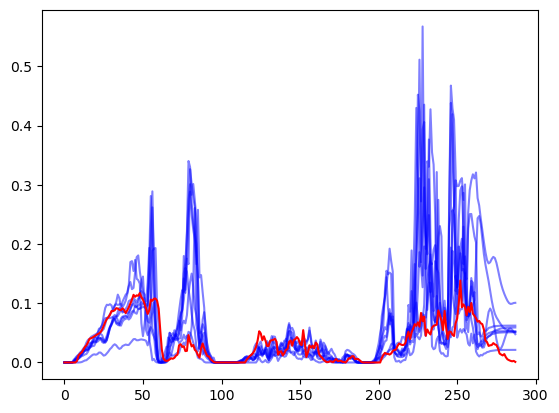

In [136]:
plt.plot(covars[:, 0], covars[:, 1:], color='blue', alpha=0.5, label='covars')
plt.plot(covars[:, 0], target, color='red', label='target');

In [137]:
def train_test_split_Nd(X, y, minute_interval=5, n_hours=8):
    """ 
    Splits the data into train and test sets.
    The test set is the last n_hours of the data.

    Args:
        X (torch.tensor): input data
        y (torch.tensor): target data
        minute_interval (int): interval between data points in minutes
        n_hours (int): number of hours to use for test set
    """
    assert X.shape[0] == y.shape[0], 'X and y must have the same number of rows'

    # number of data points in n_hours
    n_points = int(n_hours * 60 / minute_interval)

    # split data into train and test sets
    X_train = X[:-n_points, :]
    y_train = y[:-n_points]
    X_test = X[-n_points:, :]
    y_test = y[-n_points:]

    return X_train, y_train, X_test, y_test

In [138]:
covars, y_train, covars_test, y_test = train_test_split_Nd(covars, target, n_hours=2)

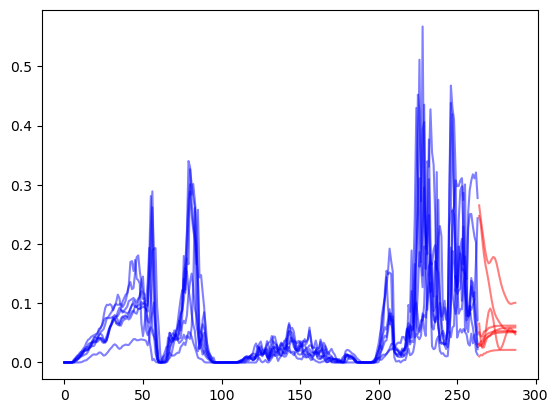

In [139]:
plt.plot(covars[:, 0], covars[:, 1:], color='blue', alpha=0.5, label='covars train');
plt.plot(covars_test[:, 0], covars_test[:, 1:], color='red', alpha=0.5, label='covars test');

In [140]:
model = ExactGPModel(train_x=covars,
                     train_y=y_train.squeeze(),
                     likelihood=likelihood,
                     mean_module=mean_module,
                     covar_module=covar_module)

model._train(n_iter=1000, lr=0.05, optim='Adam')

                     

Iter 1/1000 - Loss: 4.198
Iter 101/1000 - Loss: -2.700
Iter 201/1000 - Loss: -3.059
Iter 301/1000 - Loss: -3.097
Iter 401/1000 - Loss: -3.104
Iter 501/1000 - Loss: -3.107
Iter 601/1000 - Loss: -3.108
Iter 701/1000 - Loss: -3.108
Iter 801/1000 - Loss: -3.109
Iter 901/1000 - Loss: -3.109


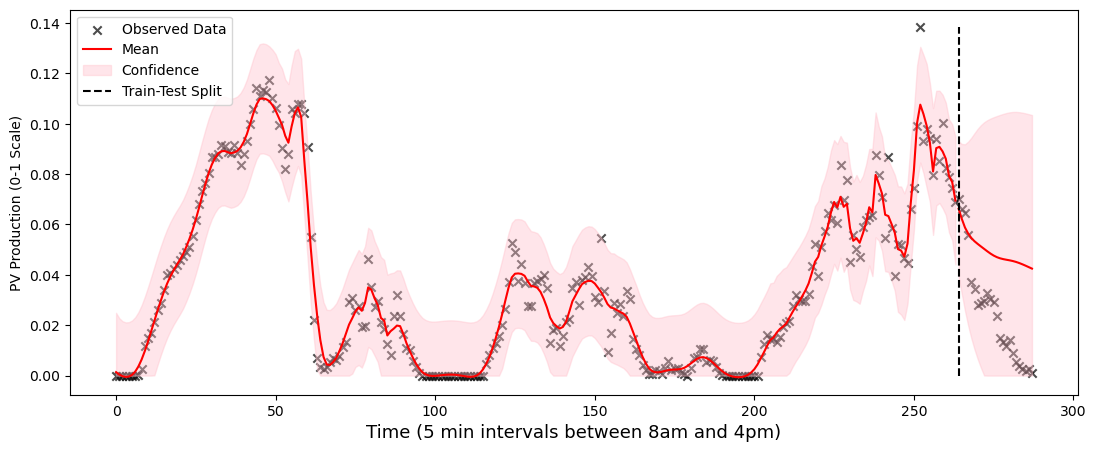

In [141]:
observed_pred, observed_pred_train = model.predict(covars_test)

# plot predictions
plt.figure(figsize=(13, 5))

plt.scatter(covars[:,0], y_train, marker='x', color='black', alpha=0.7, label='Observed Data')
plt.scatter(covars_test[:,0], y_test, marker='x', color='black', alpha=0.7)

plt.plot(covars[:,0], observed_pred_train.mean, color='r', label='Mean')

lower, upper = observed_pred_train.confidence_region()
# clip the lower and upper confidence region to avoid negative values and greater than 1
lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)
plt.fill_between(covars[:,0], lower, upper, alpha=0.4, color='pink', label='Confidence')



plt.plot(covars_test[:,0], observed_pred.mean, color='r')
lower, upper = observed_pred.confidence_region()

lower = np.clip(lower, 0, 1)
upper = np.clip(upper, 0, 1)

plt.fill_between(covars_test[:,0], lower, upper, alpha=0.4, color='pink')
plt.vlines(x= len(covars[:,0]), ymin=0, ymax=max(y_train.max(), y_test.max()), 
           color='black', linestyle='--', label='Train-Test Split')


plt.legend()

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)')

plt.show();